In [1]:
%load_ext autoreload
import sys
sys.argv.append("-lc=C:/Workspaces/AIC/simod-master/local_config_files/fido-PC.cfg")

In [2]:
from simod.init import config
from typing import List, Tuple, Dict
import roadmaptools.inout
import simod.statistics.model.edges as edges
import simod.statistics.model.transit as transit
import simod.statistics.model.ridesharing as ridesharing
import simod.statistics.model.service as service
import simod.statistics.comparisons.common as common
import matplotlib.pyplot as plt
from itertools import islice
import importlib
import simod.statistics.comparisons.sensitivity_analysis as sa


INFO:root:Loading config for project RoadmaptoolsConfig (can be overwritten later)
INFO:root:map_dir: C:/AIC Experiment Data/VGA/maps/
osm_source_url: https://s3.amazonaws.com/metro-extracts.mapzen.com/valencia_spain.osm.bz2
osm_map_filename: C:/AIC Experiment Data/VGA/maps/map.osm
filtered_osm_filename: C:/AIC Experiment Data/VGA/maps/map-filtered.osm
geojson_file: C:/AIC Experiment Data/VGA/maps/map.geojson
cleaned_geojson_file: C:/AIC Experiment Data/VGA/maps/map-cleaned.geojson
sanitized_geojson_file: C:/AIC Experiment Data/VGA/maps/map-sanitized.geojson
simplified_file: C:/AIC Experiment Data/VGA/maps/map-simplified.geojson
simplified_file_with_speed: C:/AIC Experiment Data/VGA/maps/map-simplified-speed.geojson
simplified_file_with_speed_and_curvature: C:/AIC Experiment Data/VGA/maps/map-simplified-speed-curvature.geojson
ap_nodes_file: C:/AIC Experiment Data/VGA/maps/nodes.geojson
ap_edges_file: C:/AIC Experiment Data/VGA/maps/edges.geojson
utm_center_lon: 50.0877506
utm_center_l

In [29]:
peak_experiments = {
    'delay_experiments': [
        ["vga-max_delay_3_min", "vga"],
        ["vga-lim-max_delay_3_min", "vga-lim", "vga-lim-max_delay_5_min", "vga-lim-max_delay_6_min", "vga-lim-max_delay_7_min"],
        ["vga-pnas-max_delay_3_min", "vga-pnas", "vga-pnas-max_delay_5_min", "vga-pnas-max_delay_6_min", "vga-pnas-max_delay_7_min"]
    ],
    'batch_experiments': [
        ["vga"],
        ["vga-lim", "vga-lim-batch_60s", "vga-lim-batch_90s", "vga-lim-batch_120s"],
        ["vga-pnas", "vga-pnas-batch_60s", "vga-pnas-batch_90s", "vga-pnas-batch_120s"]
    ],
    'capacity_experiments':[
        ['vga-capacity_2', "vga"],
        ['vga-lim-capacity_2', "vga-lim", 'vga-lim-capacity_10'],
        ['vga-pnas-capacity_2', "vga-pnas", 'vga-pnas-capacity_10']
    ]
}

off_peak_experiments = {
    'delay_experiments': [
        ["sw-vga-max_delay_3_min", "sw-vga", "sw-vga-max_delay_5_min", "sw-vga-max_delay_6_min"],
        ["sw-vga-lim-max_delay_3_min", "sw-vga-lim", "sw-vga-lim-max_delay_5_min", "sw-vga-lim-max_delay_6_min", "sw-vga-lim-max_delay_7_min"],
        ["sw-vga-pnas-max_delay_3_min", "sw-vga-pnas", "sw-vga-pnas-max_delay_5_min", "sw-vga-pnas-max_delay_6_min", "sw-vga-pnas-max_delay_7_min"]
    ],
    'batch_experiments': [
        ["sw-vga", "sw-vga-batch_60s", "sw-vga-batch_90s", "sw-vga-batch_120s"],
        ["sw-vga-lim", "sw-vga-lim-batch_60s", "sw-vga-lim-batch_90s", "sw-vga-lim-batch_120s"],
        ["sw-vga-pnas", "sw-vga-pnas-batch_60s", "sw-vga-pnas-batch_90s", "sw-vga-pnas-batch_120s"]
    ],
    'capacity_experiments':[
        ['sw-vga-capacity_2', "sw-vga", 'sw-vga-capacity_10'],
        ['sw-vga-lim-capacity_2', "sw-vga-lim", 'sw-vga-lim-capacity_10'],
        ['sw-vga-pnas-capacity_2', "sw-vga-pnas", 'sw-vga-pnas-capacity_10']
    ]
}

manhattan_experiments = {
    'delay_experiments': [
        ["vga-max_delay_3_min", "vga_gap_0002-start_1830-real_speeds", "vga_gap_0002-start_1830-real_speeds-delay_5_min", "vga-max_delay_6_min"],
        ["vga-lim-max_delay_3_min", "vga-lim-start_1830-real_speeds", "vga-lim-max_delay_5_min", "vga-lim-max_delay_6_min", "vga-lim-max_delay_7_min"],
        ["vga-pnas-unlimeted_vehicles-max_delay_3_min", "vga-pnas_unlimeted_vehicles-start_1830-real_speeds-delay_5_min", "vga-pnas-unlimeted_vehicles-max_delay_5_min", "vga-pnas-unlimeted_vehicles-max_delay_6_min", "vga-pnas-unlimeted_vehicles-max_delay_7_min"]
    ],
    'batch_experiments': [
        ["vga_gap_0002-start_1830-real_speeds", "vga-batch_60_s", "vga-batch_90_s", "vga-batch_120_s"],
        ["vga-lim-start_1830-real_speeds", "vga-lim-batch_60_s", "vga-lim-batch_90_s", "vga-lim-batch_120_s"],
        ["vga-pnas_unlimeted_vehicles-start_1830-real_speeds-delay_5_min", "vga-pnas-unlimeted_vehicles-batch_60_s", "vga-pnas-unlimeted_vehicles-batch_90_s", "vga-pnas-unlimeted_vehicles-batch_120_s"]
    ],
    'capacity_experiments':[
        ['vga-capacity_2', "vga_gap_0002-start_1830-real_speeds", 'vga-capacity_10'],
        ['vga-lim-capacity_2', "vga-lim-start_1830-real_speeds", 'vga-lim-capacity_10'],
        ['vga-pnas-unlimeted_vehicles-capacity_2', "vga-pnas_unlimeted_vehicles-start_1830-real_speeds-delay_5_min", 'vga-pnas-unlimeted_vehicles-capacity_10']
    ]
}
# for exp_set in manhattan_experiments.values():
#     for index, method in enumerate(exp_set):
#         new_list =  [f"Manhattan/{name}" for name in method]
#         exp_set[index] = new_list

In [4]:
loaded_edges = roadmaptools.inout.load_geojson(config.agentpolis.map_edges_filepath)
edge_data = edges.make_data_frame(loaded_edges)

[19:06:46]: Loading geojson file from: C:\AIC Experiment Data\VGA\maps\edges.geojson


In [5]:
x_values_delay = [3, 4, 5, 6, 7]
x_values_batch = [30, 60, 90, 120]
x_values_capacity = [2, 5, 10]

x_values = [x_values_batch, x_values_delay, x_values_capacity]

# Peak Experiments

In [11]:
sa.check_experiments(peak_experiments)
distance_data, comp_time_data, delay_data = sa.load_experiments(peak_experiments, edge_data)

[19:20:38]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-max_delay_3_min\ridesharing.csv to dataframe
[19:20:43]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga\ridesharing.csv to dataframe
[19:20:47]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-lim-max_delay_3_min\ridesharing.csv to dataframe
[19:20:52]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-lim\ridesharing.csv to dataframe
[19:20:57]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-lim-max_delay_5_min\ridesharing.csv to dataframe
[19:21:02]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-lim-max_delay_6_min\ridesharing.csv to dataframe
[19:21:07]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-lim-max_delay_7_min\ridesharing.csv to dataframe
[19:21:12]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-pnas-max_delay_3_min\ridesharing.csv to dataframe
[19:21:18]: Loading csv

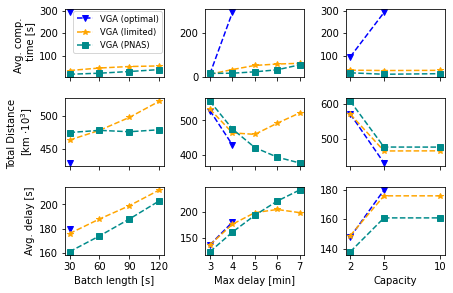

In [14]:
sa.plot_sensitivity_analysis(peak_experiments, distance_data, comp_time_data, delay_data, x_values)

In [19]:
distance_data

[528.694,
 429.258,
 532.849,
 464.028,
 459.63,
 492.067,
 521.878,
 555.84,
 475.378,
 421.344,
 393.496,
 376.576,
 429.258,
 464.028,
 478.652,
 498.319,
 522.804,
 475.378,
 478.679,
 476.585,
 479.578,
 570.807,
 429.258,
 570.496,
 464.028,
 464.385,
 608.01,
 475.378,
 475.216]

# Off-peak Experiments

In [18]:
sa.check_experiments(off_peak_experiments)
offpeak_speed_data, offpeak_tt_data, offpeak_delay_data = sa.load_experiments(off_peak_experiments, edge_data)

[19:42:15]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-max_delay_3_min\ridesharing.csv to dataframe
[19:42:17]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga\ridesharing.csv to dataframe
[19:42:18]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-max_delay_5_min\ridesharing.csv to dataframe
[19:42:20]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-max_delay_6_min\ridesharing.csv to dataframe
[19:42:22]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-lim-max_delay_3_min\ridesharing.csv to dataframe
[19:42:23]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-lim\ridesharing.csv to dataframe
[19:42:25]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-lim-max_delay_5_min\ridesharing.csv to dataframe
[19:42:27]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-lim-max_delay_6_min\ridesharing.csv to dataframe
[19:42:2

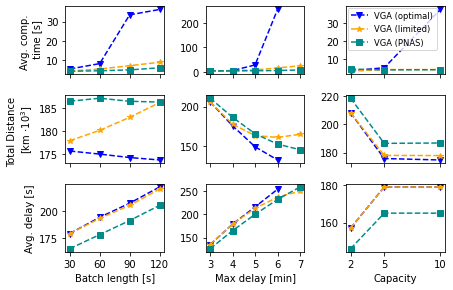

In [49]:
sa.plot_sensitivity_analysis(off_peak_experiments, offpeak_speed_data, offpeak_tt_data, offpeak_delay_data, x_values, "off_peak")

# Manhattan Experiments

In [31]:
man_exp_dir = r"C:\AIC Experiment Data\VGA Manhattan\experiments/"
sa.check_experiments(manhattan_experiments, man_exp_dir)
manhattan_speed_data, manhattan_tt_data, manhattan_delay_data = sa.load_experiments(manhattan_experiments, edge_data, man_exp_dir)

[12:00:34]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\vga-max_delay_3_min\ridesharing.csv to dataframe
[12:00:36]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\vga_gap_0002-start_1830-real_speeds\ridesharing.csv to dataframe
[12:00:37]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\vga_gap_0002-start_1830-real_speeds-delay_5_min\ridesharing.csv to dataframe
[12:00:38]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\vga-max_delay_6_min\ridesharing.csv to dataframe
[12:00:39]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\vga-lim-max_delay_3_min\ridesharing.csv to dataframe
[12:00:41]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\vga-lim-start_1830-real_speeds\ridesharing.csv to dataframe
[12:00:42]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\vga-lim-max_delay_5_min\ridesharing.csv to dataframe
[12:00

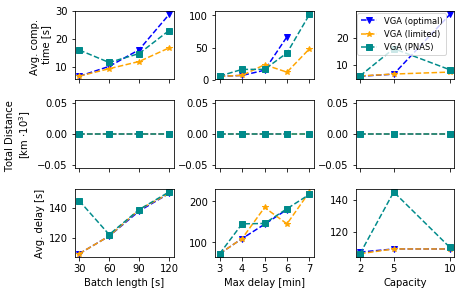

In [32]:
sa.plot_sensitivity_analysis(manhattan_experiments, manhattan_speed_data, manhattan_tt_data, manhattan_delay_data, x_values, "manhattan")

In [27]:
%autoreload
